In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, InputLayer, Input, Conv2D, BatchNormalization, MaxPool2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, Add, RandomRotation, RandomFlip, RandomContrast, GlobalAveragePooling2D, Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.train import Feature, Example, Features, BytesList, FloatList, Int64List
from tensorflow.io import TFRecordWriter, encode_jpeg, parse_single_example, decode_jpeg
from tensorflow.image import convert_image_dtype
from tensorflow.data import TFRecordDataset
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
CLASS_NAMES = ["angry","happy","sad"]
IMAGE_SIZE = 256

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train', image_size=(256,256), class_names = CLASS_NAMES, batch_size = 32, shuffle = True, seed = 99, label_mode = 'categorical')
test_ds = tf.keras.utils.image_dataset_from_directory(directory='/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test', image_size=(256,256), class_names = CLASS_NAMES, batch_size = 32, shuffle = True, seed = 99, label_mode = 'categorical')

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [5]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

# Dataset Visualization

In [6]:
# plt.figure(figsize=(12,12))
# for images,labels in train_ds.take(4):
#     for i in range(16):
#         plt.subplot(4,4,i+1)
#         plt.imshow(images[i]/255.)
#         plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])   #Class names of the position of the array where 1 is (it is categorically one-hot encoded)
#         plt.axis("off")

# Data Augmentation

In [7]:
augment_layers = Sequential([
    RandomRotation(factor = (-0.025,0.025)),
    RandomFlip(mode = 'horizontal'),
    RandomContrast(factor = 0.1)
])

In [8]:
def augment_layer(image, label):
    return augment_layers(image, training=True), label

### Cutmix Augmentation

In [9]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, IMAGE_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IMAGE_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IMAGE_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IMAGE_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IMAGE_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IMAGE_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IMAGE_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IMAGE_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [10]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IMAGE_SIZE, IMAGE_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IMAGE_SIZE, IMAGE_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IMAGE_SIZE*IMAGE_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [11]:
train_ds_1 = train_ds.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_ds_2 = train_ds.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_ds = tf.data.Dataset.zip((train_ds_1, train_ds_2))

In [12]:
train_ds = mixed_ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)#.prefetch(tf.data.AUTOTUNE)

# Dataset Preparation

In [13]:
# train_ds = train_ds.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [14]:
resize_rescale = Sequential([
    Resizing(256,256),
    Rescaling(1./255)
])

# TF Records

Do not use prefetch for train or test_ds during dataset preparation

In [15]:
# train_ds = train_ds.unbatch()
# test_ds = test_ds.unbatch()

In [16]:
# def createExample(image, label):
    
#     bytes_feature = Feature(   
#         bytes_list = BytesList(value = [image]))   # We use byte value to represent the image (it is in bytes)
#     int_feature = Feature(
#         int_list = Int64List(value = label))     # We use int value to represent the label (matrix of 0 and 1 in one-hot encoded form)

#     example = Example(
#         features = Features(feature = {
#             'images' : bytes_feature,
#             'labels' : int_feature,
#         }))

#     return example.SerializeToString()

In [17]:
# NUM_SHARDS = 10    # How many shards we want to divide the total record into
# PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [18]:
# def encode(image, label):
#     image = convert_image_dtype(image, dtype = tf.uint8)
#     image = encode_jpeg(image)
#     return image, label

In [19]:
# encoded_ds = train_ds.map(encode)   #Converts the train_ds into byte form so that it matches the TF record shard byte datatype, instead of Tensor dtype

In [20]:
# for shard_number in range(NUM_SHARDS):
#     shard_ds = encoded_ds.shard(NUM_SHARDS, shard_number).as_numpy_iterator   #Splits train_ds into 10 shard_ds, one for each loop
#     with TFRecordWriter(PATH.format(shard_number)) as file_writer:
#         for image, label in shard_ds:
#             example = create_example(image, label)
#             file_writer.write(example)

In [21]:
# new_ds = TFRecordDataset(filenames = [PATH.format(p) for p in range(NUM_SHARDS)])   # Convert the shard ds back to Tensorflow ds 

In [22]:
# def parse(example):
    
#     feature_description = {
#         'images' : FixedLenFeature([], tf.string),
#         'labels' : FixedLenFeature([], tf.int64),
#     }
#     example = parse_single_example(example, feature_description)
#     example['images'] = decode_jpeg(example["images"], channels = 3)   #Convert from byte back to Tensor
    
#     return example['images'], example['labels']

In [23]:
# train_ds = new_ds.map(parse).batch(CONFIGURATION['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)  #New train_ds is now the same dimensions as original train_ds

# Building model

### Lenet

In [24]:
lenet_model = Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),  #Softmax because 3 end classes

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

### ResNet

In [25]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):   #Add training so that BatchNormalization params are in training mode

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [26]:
class ResidualBlock(Layer):    # Creates each residual block
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)    # False if 1 stride, True if more

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")  #This is where we can change strides in the model; kernel size is 3
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
  def call(self, input, training):  #Calls the defined layers

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:    #if-else implements the 'addition' of the residual block, which chooses the new output or original input
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [27]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
     
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')   #64 7x7 filters with stride 2
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)   #conv2 residual block, 3 layers with 64 3x3 channels
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2) #conv3 residual block, 4 layers with 128 3x3 channels; the 2 represents stride
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2) #conv4 residual block
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2) #conv5 residual block
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
    
  def call(self, x, training = True):   # Call all the layers
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    
    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    
    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)
    
    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [28]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = True)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.33333334, 0.33333334, 0.33333334]], dtype=float32)>

In [29]:
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### EfficientNet (Transfer Learning)

In [30]:
backbone = EfficientNetB4(
    include_top = False,   # We set to False because we only want the feature extractor part, not the whole model output layer included
    weights = 'imagenet',  # Weights are pretrained on imagenet dataset
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION['IM_SIZE'], 3)
#     pooling=None,
#     classes=1000,   # It was trained 1000 epochs  # Lines below this are off due to include_top = False
#     classifier_activation='softmax',
#     **kwargs
)

71686520/71686520 [==============================] - 4s 0us/step


In [31]:
backbone.trainable = False # Freezes the backbone so that it cannot be changed again

In [35]:
efficient_model = Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu'),
    Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax'),
])

efficient_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_41 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                      

### Fine-tuning EfficientNet

In [ ]:
backbone.trainable = True   # Make the model trainable for fine-tuning, train the model before fine-tuning, trainable is False while model is trained, then recompile model after fine-tuning then retrain

In [ ]:
inp = Input(shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)) # Converting the Sequential model to Functional model
x = backbone(inp, training = False)    # BatchNormalization is now in inference mode so as to not change the model weights; different from trainable
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(CONFIGURATION['N_DENSE_2'], activation = 'relu')(x)
output = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')(x)

fine_model = Model(inp, output)

In [ ]:
fine_model.summary()

# Training model

In [36]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',    # Saves best weights
    monitor = 'val_accuracy', 
    mode = 'max',
    verbose = 1,
    save_best_only = True
)

In [37]:
loss_function = CategoricalCrossentropy()  #If labels are one-hot encoded, use categorical; if it is int, use sparsecat
#Here, the label is in form [0,1,0], hence the output will be of [x,y,z] form, which indicates the percentage of happy,sad,angry in the picture

For categorical accuracy, we check the one-hot encoded y_true and y_pred. If the label indicated by y_true (the one having the highest value) is same as that of y_pred, we add 1, otherwise we add 0. Then, we divide total by the total number of labels. For top K cat accuracy (k=2), we choose the 2 highest values in y_pred, and check if any of them matches the label in y_true, if so then 1, i.e. more leeway than normal accuracy.

In [38]:
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]  

In [39]:
fine_model.compile(optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']*0.01),   # x10 LR in case of ResNet, x0.01 LR in case of fine-tuning training
                   loss = loss_function,
                   metrics = metrics)

In [40]:
history = efine_model.fit(
            train_ds,
            validation_data = test_ds,
            epochs = 20,    #More for resnet
            verbose = 1,
            callbacks = [checkpoint_callback])

Epoch 1/20


2024-02-28 05:58:39.734500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709099925.071472     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


213/213 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.6176 - top_k_accuracy: 0.8538
Epoch 1: val_accuracy improved from -inf to 0.69227, saving model to best_weights
213/213 [==============================] - 140s 573ms/step - loss: 1.0794 - accuracy: 0.6176 - top_k_accuracy: 0.8538 - val_loss: 0.7075 - val_accuracy: 0.6923 - val_top_k_accuracy: 0.8745
Epoch 2/20
213/213 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.6655 - top_k_accuracy: 0.8742
Epoch 2: val_accuracy improved from 0.69227 to 0.70061, saving model to best_weights
213/213 [==============================] - 114s 532ms/step - loss: 0.8252 - accuracy: 0.6655 - top_k_accuracy: 0.8742 - val_loss: 0.6638 - val_accuracy: 0.7006 - val_top_k_accuracy: 0.8946
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.6910 - top_k_accuracy: 0.8938
Epoch 3: val_accuracy improved from 0.70061 to 0.71949, saving model to best_weights
213/213 [=========

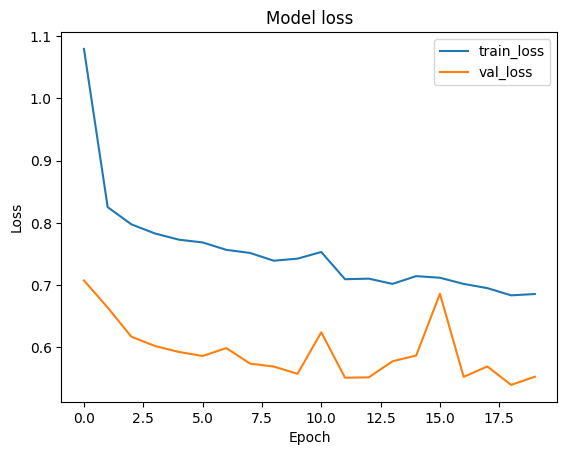

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

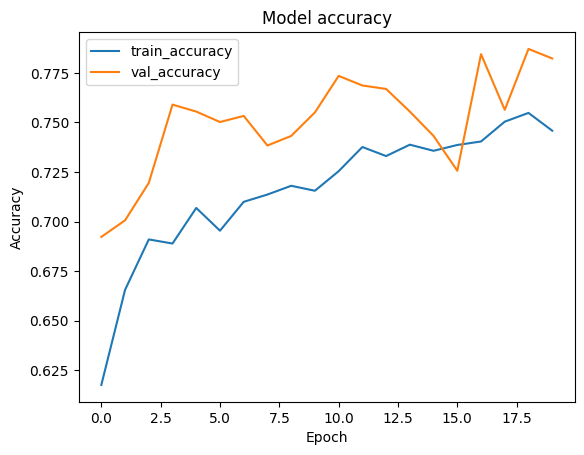

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Evaluation

In [43]:
fine_model.load_weights('best_weights')

In [44]:
fine_model.evaluate(test_ds)

72/72 [==============================] - 8s 113ms/step - loss: 0.5395 - accuracy: 0.7871 - top_k_accuracy: 0.9311


[0.5395440459251404, 0.7870939373970032, 0.9310799241065979]

In [51]:
img = cv2.imread('/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/137981.jpg_brightness_2.jpg')
img = cv2.resize(img, (256,256))
img = tf.constant(img, dtype='float32')
img = tf.expand_dims(img, axis=0)  #Add the batch dimension
CLASS_NAMES[tf.argmax(fine_model(img), axis=-1).numpy()[0]]   #Takes the class name of the y_pred label having the max value

'sad'

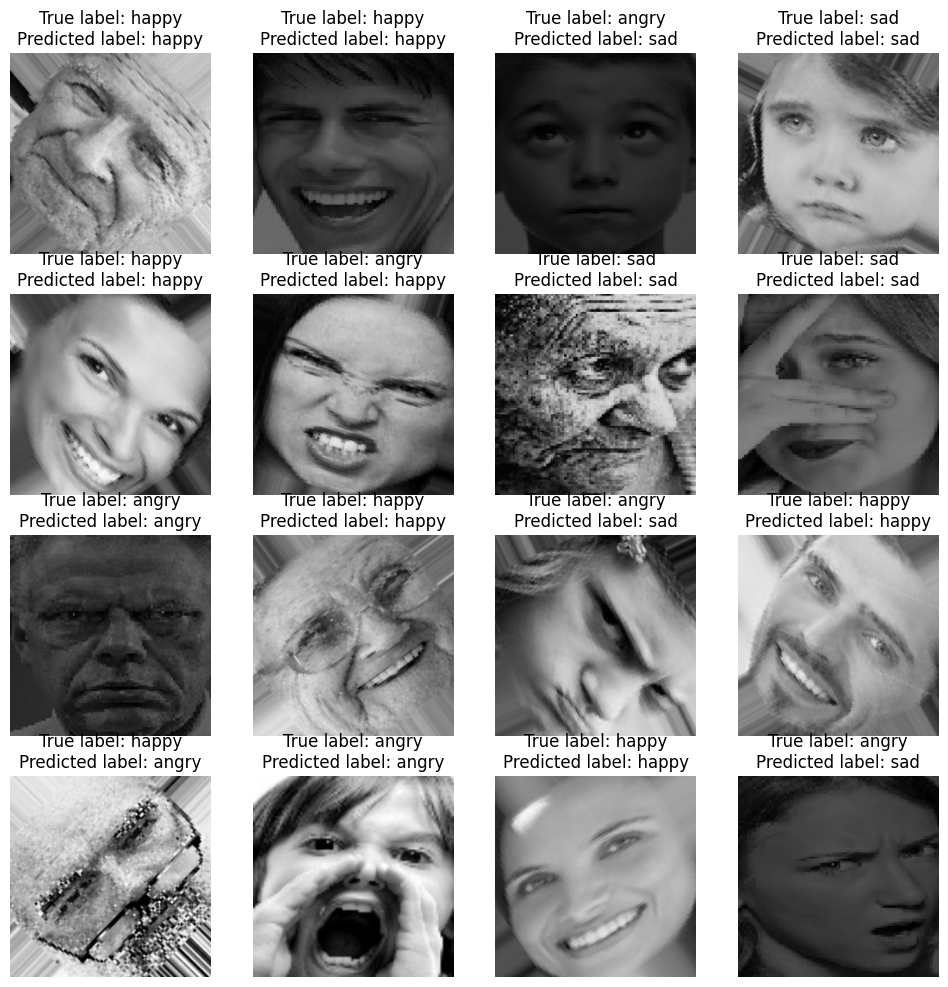

In [52]:
plt.figure(figsize = (12,12))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        im = tf.expand_dims(images[i], axis=0)
        plt.title("True label: " + CLASS_NAMES[tf.argmax(labels[i]).numpy()] + "\nPredicted label: " + CLASS_NAMES[tf.argmax(fine_model(im), axis=-1).numpy()[0]])
        plt.axis("off")

# Visualization

###  Visualizing intermediate layers

In [ ]:
backbone = VGG16(
    include_top=False,
    weights='imagenet',
#     input_tensor=None,
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)
#     pooling=None,    # Because include_top is False
#     classes=1000,
#     classifier_activation='softmax'
)

In [ ]:
backbone.summary()    # 256x256x3 --> 8x8x512

In [ ]:
def is_conv(layer_name):
    if 'conv' in layer_name:
        return True
    return False

In [ ]:
# To visualize, we make the hidden conv layers as the outputs to check what they represent
feature_maps = [layer.output for layer in backbone.layers[1:] if is_conv(layer.name)]   # All the conv layers after the first (hidden conv layers)
feature_model = Model(
    inputs = backbone.input,
    outputs = feature_maps   # The feature map has all the hidden layer outputs, so we can visualize all of them now
)

feature_model.summary()

In [ ]:
img = cv2.imread('/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/137981.jpg_brightness_2.jpg')
img = cv2.resize(img, (256,256))
img = tf.constant(img, dtype='float32')
img = tf.expand_dims(img, axis=0)

f_maps = feature_model.predict(img)

In [ ]:
for i in range(len(f_maps)):
    print(f_maps[i].shape)   # We see each shape corresponds to an intermediate layer

In [ ]:
for i in range(len(f_maps)):
    plt.figure(figsize = (256,256))
    f_size = f_maps[i].shape[1]   # 1x256x256x64, pick 256
    n_channels = f_maps[i].shape[3] # Num of channels is 64 in above example
    joint_maps = np.ones((f_size, f_size * n_channels))   # This array aligns all the channels side by side instead of in a 3D way, where f_size is the height of the array, and f_size * n_channels is the width of the array (each channel has width f_size and they're laid side by side)
    
    ax = plt.subplot(len(f_maps), 1, i+1)
    
    for j in range(n_channels):
        joint_maps[:, f_size*j : f_size*(j+1)] = f_maps[i][...,j]  # joint_maps skip the width by f_size (256, say) per loop, adding one 256x256 channel each time till all channels are added
    
    plt.imshow(joint_maps[:, 0:512])
    plt.axis('off')

# Confusion Matrix

In [53]:
predicted = []
labels = []

for im, label in train_ds:
    predicted.append(fine_model(im))
    labels.append(label.numpy())

In [54]:
true = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1)]) #We concatenate all batches except last batch (32 each), with the last batch labels[-1] (it may not be 32) to prevent error
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1)])

[[ 706  263  556]
 [  73 2520  426]
 [  62  266 1927]]


Text(0.5, 58.7222222222222, 'Predicted')

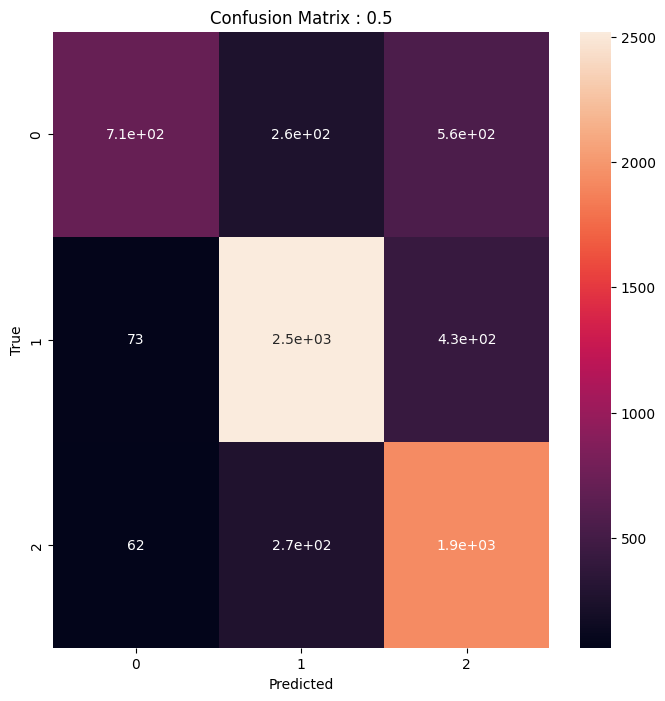

In [55]:
threshold = 0.5

cm = confusion_matrix(true, pred)
print(cm)
plt.figure(figsize = (8,8))

sns.heatmap(cm, annot=True,)
plt.title("Confusion Matrix : {}".format(threshold))
plt.ylabel('True')
plt.xlabel('Predicted')